In [1]:
import numpy as np; np.set_printoptions(suppress=True, linewidth=100); np.seterr(divide='ignore')
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt
from scipy.linalg import expm

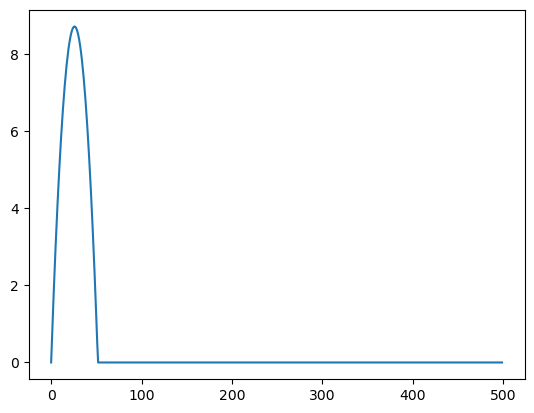

birth rate drops to 0 at NSS = 52
this occurs at 52 wt and 104 mt


In [3]:
# NSS = 21
# C = 0.013
# K = 0.4
# DELTA = 0.5

NSS = 21
C = 0.013
K = 0.4
DELTA = 0.5

pop_range = np.arange(0, 500)
birth_rate = np.array([pop*max(0, K+C*(NSS-pop)) for pop in pop_range])
plt.plot(pop_range, birth_rate)
plt.show()
zero_births_wt = np.where(birth_rate == 0)[0][1]
zero_births_mt = int(zero_births_wt*(1/DELTA))
print('birth rate drops to 0 at NSS =', zero_births_wt)
print(f'this occurs at {zero_births_wt} wt and {zero_births_mt} mt') 

In [4]:
def rate_calculator(
    wt, mt, 
    Nss = NSS, c= C, k = K, delta = DELTA
):
    # wt_birth = round( wt*max(0.0, k+(C*(Nss-wt-(delta*mt)))) ,8)
    # mt_birth = round( mt*max(0.0, k+(C*(Nss-wt-(delta*mt)))) ,8)
    # wt_death = round( wt*k ,8)
    # mt_death = round( mt*k ,8)
    
    wt_birth = wt*max(0.0, k+(C*(Nss-wt-(delta*mt))))
    mt_birth = mt*max(0.0, k+(C*(Nss-wt-(delta*mt))))
    wt_death = wt*k
    mt_death = mt*k

    return wt_birth, mt_birth, wt_death, mt_death

In [5]:
wt_init_state = 14

wt_state_start = 0
wt_state_end = zero_births_wt

wt_state_range = 1+wt_state_end-wt_state_start
wt_states = [i for i in range(wt_state_start, wt_state_end+1)]

mt_init_state = 14

mt_state_start = 0
mt_state_end = zero_births_mt

mt_state_range = 1+mt_state_end-mt_state_start
mt_states = [i for i in range(mt_state_start, mt_state_end+1)]

# get joint states
states = [[(wt,mt) for mt in range(mt_state_start, mt_state_end+1)] for wt in range(wt_state_start, wt_state_end+1)]
states_flat = [item for row in states for item in row]
n_states = len(states_flat)
init_state_index = states_flat.index((wt_init_state, mt_init_state))

print(n_states, 'states')
print(f'matrices will be {n_states}*{n_states} and take {round((n_states*n_states*8)/ (1024 ** 3) ,4)} GB')

# get heteroplasmy of each state
state_heteroplasmy = np.array([state[1]/(state[0]+state[1]) if state[0]+state[1] > 0.0 else np.NaN for state in states_flat])

# get effective population size of each state
state_eps = np.array([state[0]+(state[1]*DELTA) for state in states_flat])

# get total copy number of each state
state_ps = np.array([state[0]+state[1] for state in states_flat])

5565 states
matrices will be 5565*5565 and take 0.2307 GB


In [9]:
transition_rate_matrix = np.zeros((n_states, n_states), dtype = np.float64)
for i in range(n_states):
    for j in range(n_states):
        if i != j:
            # collect counts of wt and mt in both states

            i_wt = states_flat[i][0]
            i_mt = states_flat[i][1]
            j_wt = states_flat[j][0]
            j_mt = states_flat[j][1]

            if i_wt == j_wt or i_mt == j_mt:
                
                
                wt_birth, mt_birth, wt_death, mt_death = rate_calculator(i_wt, i_mt)

                ## DETERMINE RATE BY TYPE OF TRANSITION
                # transition is wt birth
                if   i_wt+1 == j_wt and i_mt == j_mt:
                    rate = wt_birth
                    #print(states_flat[i], states_flat[j], rate, 'wt birth')
                
                # transition is mt birth
                elif i_mt+1 == j_mt and i_wt == j_wt:
                    rate = mt_birth
                    #print(states_flat[i], states_flat[j], rate, 'mt birth')
                
                # transition is wt death
                elif i_wt-1 == j_wt and i_mt == j_mt:
                    rate = wt_death
                    #print(states_flat[i], states_flat[j], rate, 'wt death')
                
                # transition is mt death
                elif i_mt-1 == j_mt and i_wt == j_wt:
                    rate = mt_death
                    #print(states_flat[i], states_flat[j], rate, 'mt death')
                
                else:
                    rate = 0.0
                
                transition_rate_matrix[i,j] = rate
                
        
    print(f'Transition rate matrix calculation {round(((i+1)/n_states)*100, 2)}% complete     ', end = '\r')

for i in range(n_states):
    transition_rate_matrix[i, i] = -np.sum(transition_rate_matrix[i,:])

#print(transition_rate_matrix)

print("\nTransition rate matrix:")
df = pd.DataFrame(data=transition_rate_matrix, index=states_flat, columns=states_flat)
print(df)

Transition rate matrix calculation 100.0% complete     
Transition rate matrix:
           (0, 0)  (0, 1)  (0, 2)  (0, 3)  (0, 4)  (0, 5)  (0, 6)  (0, 7)  (0, 8)  (0, 9)  ...  (53, 96)  (53, 97)  (53, 98)  (53, 99)  (53, 100)  (53, 101)  (53, 102)  (53, 103)  (53, 104)  (53, 105)
(0, 0)       -0.0  0.0000  0.0000  0.0000  0.0000   0.000     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0        0.0        0.0        0.0        0.0        0.0        0.0
(0, 1)        0.4 -1.0665  0.6665  0.0000  0.0000   0.000     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0        0.0        0.0        0.0        0.0        0.0        0.0
(0, 2)        0.0  0.8000 -2.1200  1.3200  0.0000   0.000     0.0     0.0     0.0     0.0  ...       0.0       0.0       0.0       0.0        0.0        0.0        0.0        0.0        0.0        0.0
(0, 3)        0.0  0.0000  1.2000 -3.1605  1.9605   0.000     0.0     0.0     0.0     0.0  ...       0.0       0.0  

In [14]:
T = 600
transition_prob_matrix = expm(transition_rate_matrix*T)
print("Transition probability matrix at time T")
print(transition_prob_matrix)

Transition probability matrix at time T
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.61089846 0.00000283 0.00000377 ... 0.         0.         0.        ]
 [0.37738085 0.00000452 0.00000603 ... 0.         0.         0.        ]
 ...
 [0.11096837 0.00000478 0.00000637 ... 0.         0.         0.        ]
 [0.11025516 0.00000479 0.00000639 ... 0.         0.         0.        ]
 [0.10955116 0.00000481 0.00000641 ... 0.         0.         0.        ]]


In [15]:
initial_state_dist = np.zeros(n_states)
initial_state_dist[init_state_index] = 1

state_dist = initial_state_dist @ transition_prob_matrix
state_dist_mat = np.reshape(state_dist, (wt_state_range, mt_state_range))
print(f"State distribution at time T = {T}:")
print(state_dist_mat)

wt_marginal = np.sum(state_dist_mat, axis = 1)
print("\nMarginal distribution on wt:")
print(wt_marginal)
mt_marginal = np.sum(state_dist_mat, axis = 0)
print("\nMarginal distribution on mt:")
print(mt_marginal)


print("\nStats:")

wt_expected_value = np.average(wt_states, weights=wt_marginal)
mt_expected_value = np.average(mt_states, weights=mt_marginal)
print("> Expected population sizes:")
print("\t wt:", round(wt_expected_value, 2),", mt:", round(mt_expected_value ,2))


effective_pop_size = np.average(state_eps, weights = state_dist)
print("> Expected effective population size:")
print("\t",round(effective_pop_size, 2))


pop_size = np.average(state_ps, weights = state_dist)
print("> Expected copy number:")
print("\t",round(pop_size, 2))


p_pop0 = state_dist_mat[0,0]
print("> Extinction probability:")
print("\t",round(p_pop0, 4))


het_valid_mask = ~np.isnan(state_heteroplasmy)
het_valid_data = state_heteroplasmy[het_valid_mask]
het_valid_weights = state_dist[het_valid_mask]
het_weighted_mean = np.sum(het_valid_data * het_valid_weights) / np.sum(het_valid_weights)
print("> Expected heteroplasmy:")
print("\t",round(het_weighted_mean, 4))


p_het_1 = round(np.sum(state_dist_mat[0,:])-p_pop0 ,4)
p_het_0 = round(np.sum(state_dist_mat[:,0])-p_pop0 ,4)
print("> Takeover probabilities:")
print("\t wt:", p_het_1,", mt:", p_het_0)

State distribution at time T = 600:
[[0.16556497 0.00000361 0.00000482 ... 0.         0.         0.        ]
 [0.00059397 0.         0.         ... 0.         0.         0.        ]
 [0.00078649 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Marginal distribution on wt:
[0.6633318  0.00059397 0.00078649 0.00104528 0.00139    0.00184382 0.00243284 0.00318469 0.00412627
 0.00528041 0.00666154 0.00827056 0.01008955 0.01207709 0.01416534 0.0162599  0.01824356 0.01998449
 0.0213485  0.02221436 0.02249008 0.02212736 0.02113136 0.01956344 0.01753564 0.01519738 0.01271649
 0.01025796 0.00796436 0.00594139 0.00425076 0.00291083 0.00190366 0.00118618 0.00070237 0.00039407
 0.00020882 0.00010414 0.00004867 0.00002122 0.00000859 0.00000321 0.0000011  0.00000034 0